In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import os
import shap
from mlp_torch2_esg import RatingsNet, import_data

Model will run on cpu.


In [2]:
plt.style.use('ggplot')

# Recreate Neural Network and import functions

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# assert torch.cuda.get_device_name(0) == 'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Model will run on {device}.")

torch.manual_seed(42)

cols_to_keep = ['Current Ratio',
'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
'EBIT Margin', 'Asset Turnover',
'ROE - Return On Equity', 'Return On Tangible Equity',
'Operating Cash Flow Per Share', 'Free Cash Flow Per Share', 'ESG Rating', 'ESG to Sector Average']

cols_to_keep_categorical = ['Sector']

df = import_data()


X = df[cols_to_keep]
y = df.loc[:, df.columns == 'Rating Category Encoded'].to_numpy()

onehot = OneHotEncoder(sparse_output=False).fit(y)
y = onehot.transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = np.append(X, df['Sector'].to_numpy().reshape(-1, 1), axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

Model will run on cpu.


In [4]:
model = RatingsNet(input_shape=X_train.shape[1])

model.load_state_dict(torch.load(os.path.join('torch_weights', 'best_weights_esg.pt')))

<All keys matched successfully>

# Calculate SHAP-values (will partially use GPU for tensor operations)

C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 1570/1570 [11:53<00:00,  2.20it/s]


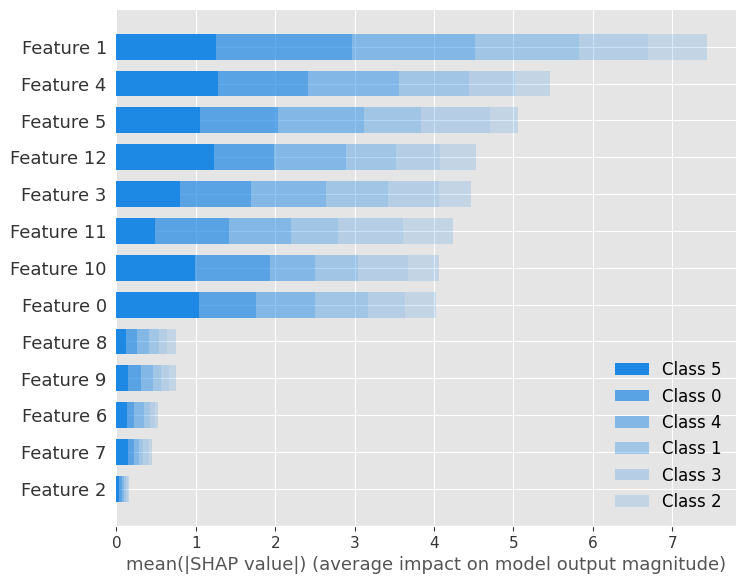

In [5]:
torch.set_num_threads(6)

# use kmeans to summarize the dataset

kmeans_background = shap.kmeans(X_train.detach().cpu().numpy(), 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def f(X):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy()

explainer = shap.KernelExplainer(f, kmeans_background)
shap_values = explainer.shap_values(X_test.detach().cpu().numpy())
shap.summary_plot(shap_values, X_test.detach().cpu().numpy())

## Create in-depth class analysis with beeswarm plots

C:\Users\leand\AppData\Local\Temp\ipykernel_11392\1339225506.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap(Color01,128)
C:\Users\leand\AppData\Local\Temp\ipykernel_11392\1339225506.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap(Color04,128)
C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\shap\plots\summary.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,


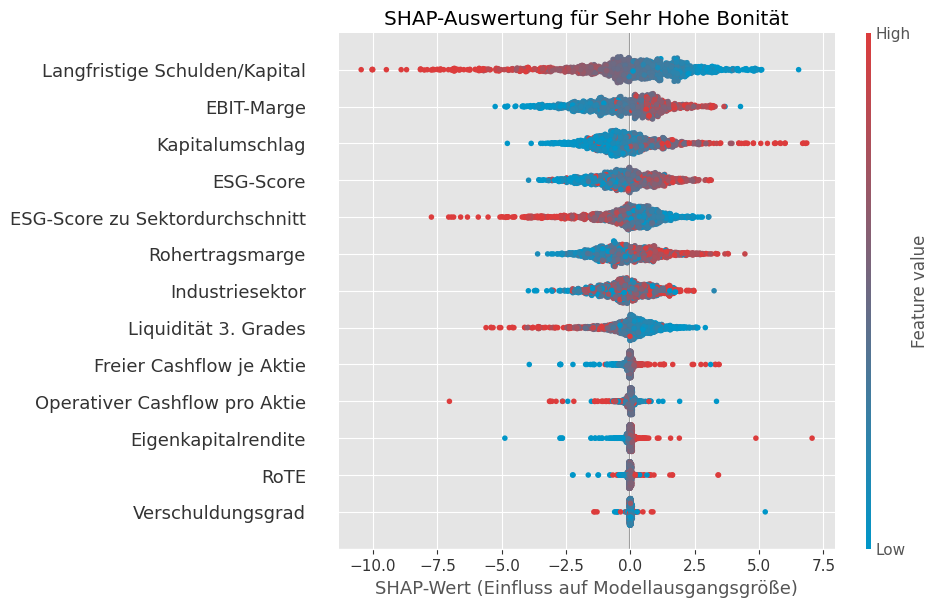

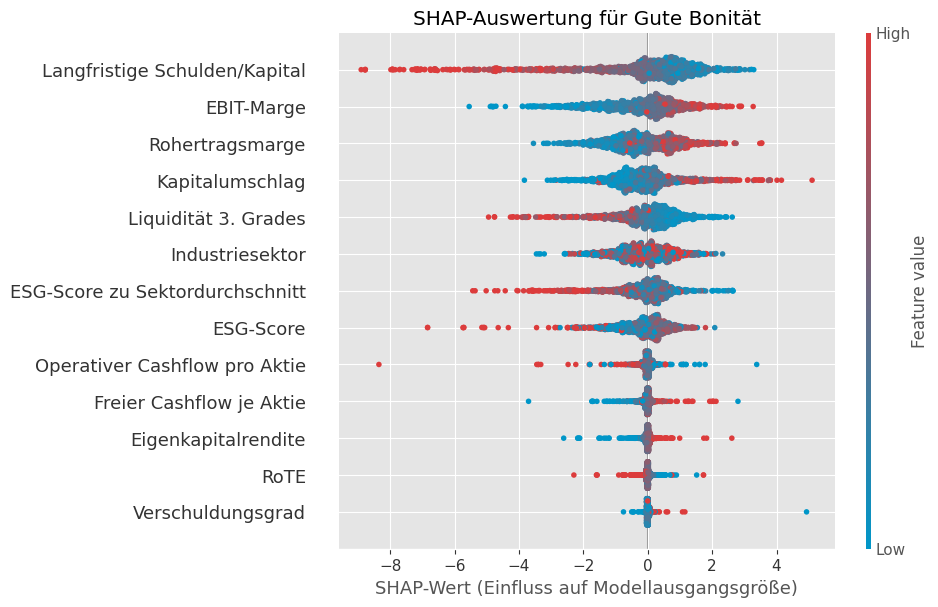

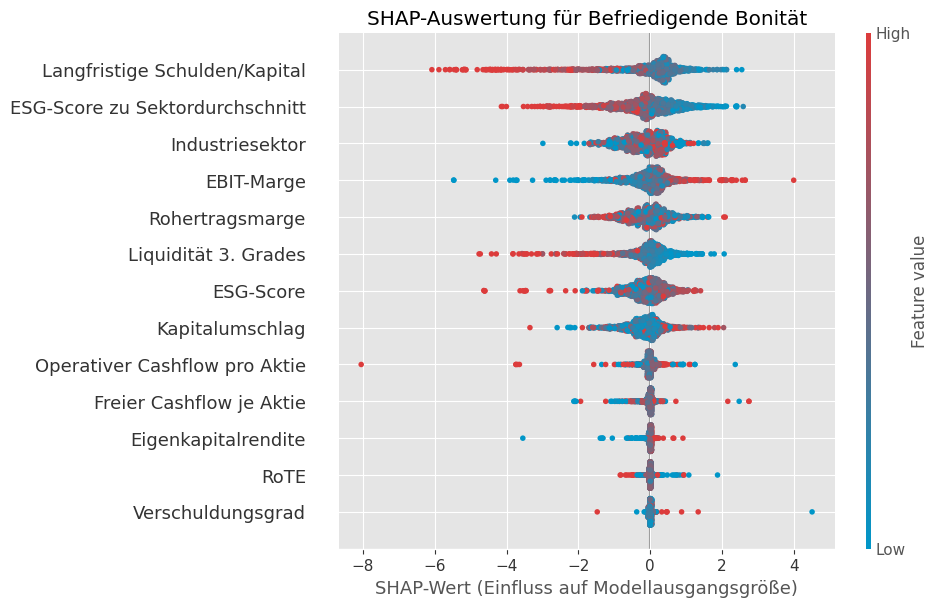

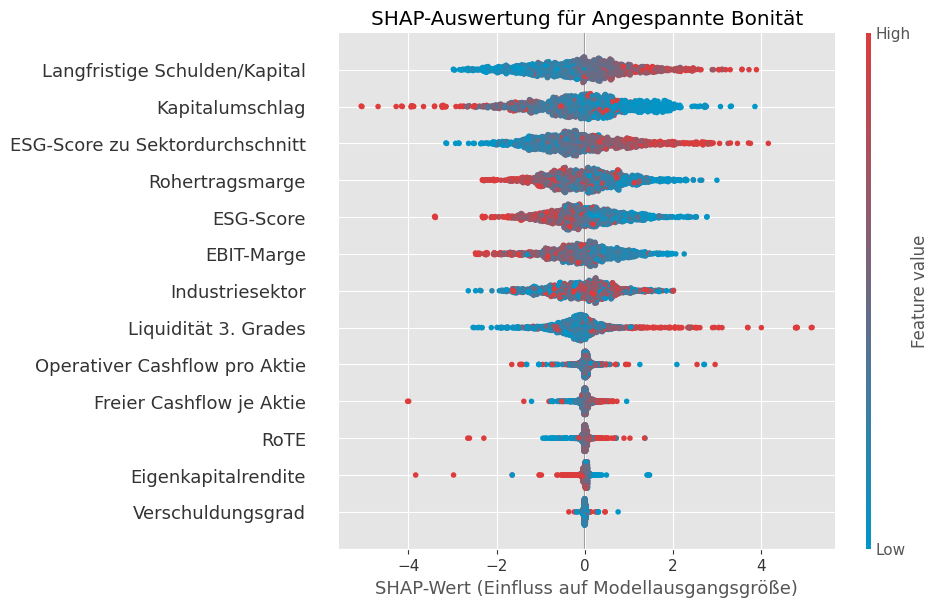

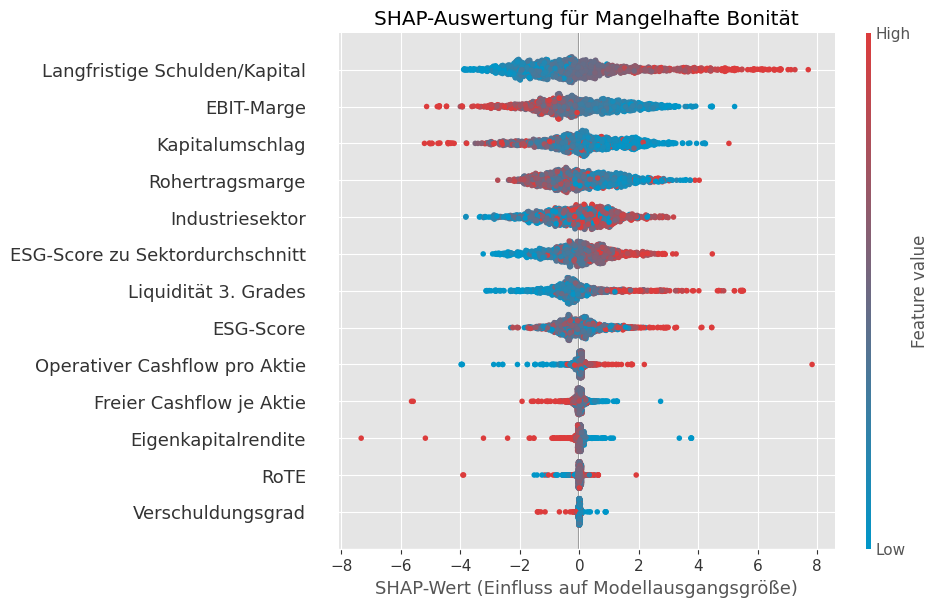

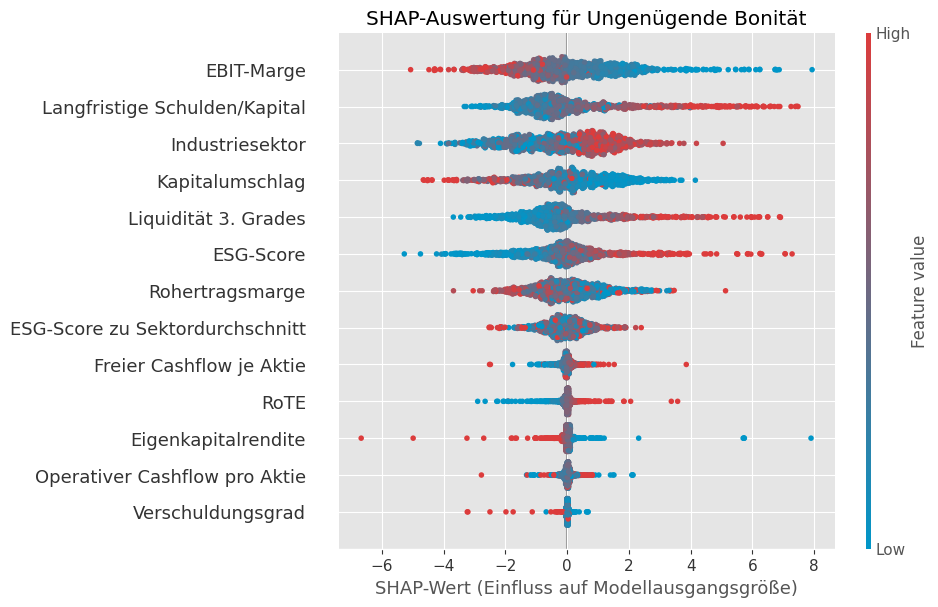

In [6]:
feature_names = ['Current Ratio',
    'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
    'EBIT Margin', 'Asset Turnover',
    'ROE - Return On Equity', 'Return On Tangible Equity',
    'Operating Cash Flow Per Share', 'Free Cash Flow Per Share', 'ESG Rating', 'ESG to Sector Average', 'Sector']

features_np = np.array(feature_names)

columns_german = {
    'Gross Margin': 'Rohertragsmarge', 'Current Ratio': 'Liquidität 3. Grades', 'Long-term Debt / Capital': 'Langfristige Schulden/Kapital', 'Debt/Equity Ratio': 'Verschuldungsgrad',
    'EBIT Margin': 'EBIT-Marge', 'Asset Turnover': 'Kapitalumschlag', 'ROE - Return On Equity': 'Eigenkapitalrendite', 'Return On Tangible Equity': 'RoTE',
        'Operating Cash Flow Per Share': 'Operativer Cashflow pro Aktie', 'Free Cash Flow Per Share': 'Freier Cashflow je Aktie', 'Sector': 'Industriesektor', 'ESG Rating': 'ESG-Score',
        'ESG to Sector Average': 'ESG-Score zu Sektordurchschnitt'
        }

feature_names = np.vectorize(columns_german.get)(features_np)

RGB_val = 255

color01= (0,150,200)  # Blue wanted
color04= (220,60,60)  # red wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for R,G,B in Colors]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]



GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')


class_names = ['Sehr Hohe Bonität', 'Gute Bonität', 'Befriedigende Bonität', 'Angespannte Bonität', 'Mangelhafte Bonität', 'Ungenügende Bonität']

for i, class_name in enumerate(class_names):
  plt.figure()
  shap.summary_plot(shap_values[i], X_test.detach().cpu().numpy(), show=False, feature_names=feature_names)
  ax = plt.gca()
  ax.set_xlabel('SHAP-Wert (Einfluss auf Modellausgangsgröße)')
  plt.gcf().axes[-1].set_aspect(100)
  plt.gcf().axes[-1].set_box_aspect(100)
  plt.title(f'SHAP-Auswertung für {class_name}')

  # Change the colormap of the artists
  for fc in plt.gcf().get_children():
      for fcc in fc.get_children():
          if hasattr(fcc, "set_cmap"):
              fcc.set_cmap(newcmp)

  plt.savefig(os.path.join('torch_eval', 'esg_model', 'shap_values', f'{class_name}_shap.png'), bbox_inches='tight', dpi=300)

## Feature importance based on absolute SHAP-values

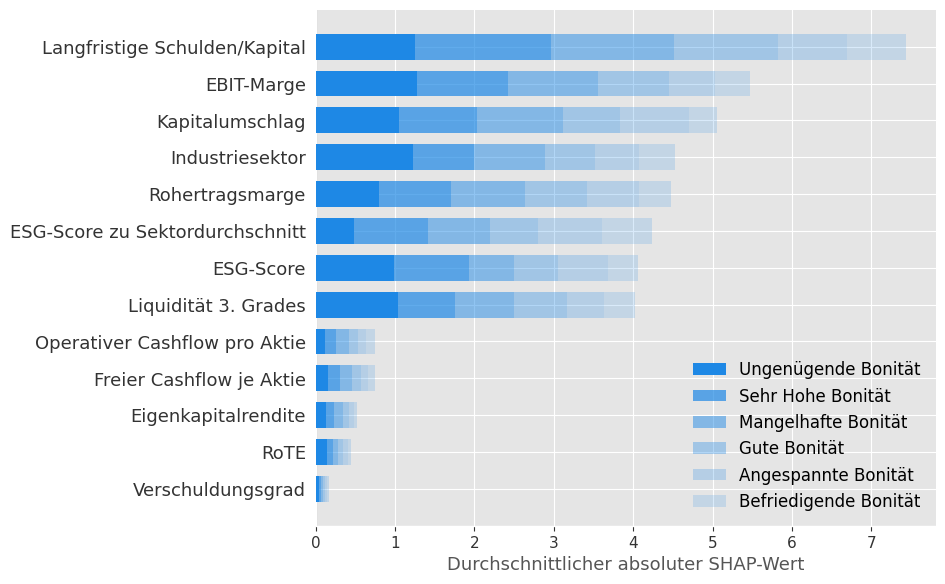

In [7]:
# feature_names = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio', 
#                  'Gross Margin', 'EBIT Margin', 'Asset Turnover', 'ROE - Return On Equity', 
#                  'Return On Tangible Equity', 'Operating Cash Flow Per Share', 
#                  'Free Cash Flow Per Share', 'ESG Rating', 'Sector']


class_names = ['Sehr Hohe Bonität', 'Gute Bonität', 'Befriedigende Bonität', 'Angespannte Bonität', 'Mangelhafte Bonität', 'Ungenügende Bonität']


plt.figure()
shap.summary_plot(shap_values, X_test.detach().cpu().numpy(), feature_names=feature_names, class_names=class_names, show=False)
summ = plt.gca()
summ.set_xlabel('Durchschnittlicher absoluter SHAP-Wert')
plt.show()

In [8]:
esg_index = 11
class_names_table = []
mean_shap_values_table = []
feature_names_table = []
for j, feature_name in enumerate(feature_names):
    
    for i, class_name in enumerate(class_names): 
        # Filter based on the ESG values in X_test
        mean_esg = X_test[:, j].detach().cpu().numpy().mean()
        valid_indices = X_test[:, j].detach().cpu().numpy() > mean_esg
        filtered_shap_values_for_esg = shap_values[i][valid_indices, j]

        # Compute the mean SHAP value for the ESG feature
        mean_shap_value = np.mean(filtered_shap_values_for_esg)
        # print(f"Mean SHAP value for {class_name} where ESG > 0: {mean_shap_value}")
        class_names_table.append(class_name)
        mean_shap_values_table.append(mean_shap_value)
        feature_names_table.append(feature_name)


df_analysis = pd.DataFrame(data={'Feature': feature_names_table, 'Klasse': class_names_table, 'Durchschnittswert': mean_shap_values_table})

df_analysis.loc[df_analysis['Feature'] == 'ESG-Score zu Sektordurchschnitt']


,Feature,Klasse,Durchschnittswert
66,ESG-Score zu Sektordurchschnitt,Sehr Hohe Bonität,-1.100745
67,ESG-Score zu Sektordurchschnitt,Gute Bonität,-0.566332
68,ESG-Score zu Sektordurchschnitt,Befriedigende Bonität,-0.733122
69,ESG-Score zu Sektordurchschnitt,Angespannte Bonität,0.705169
70,ESG-Score zu Sektordurchschnitt,Mangelhafte Bonität,0.684822
71,ESG-Score zu Sektordurchschnitt,Ungenügende Bonität,-0.008773


In [9]:
# X_test[:, 11].detach().cpu().numpy().mean()

shap_values[3][:, 11].mean()

-0.09810967022002995

## Feature importance based on permuatation

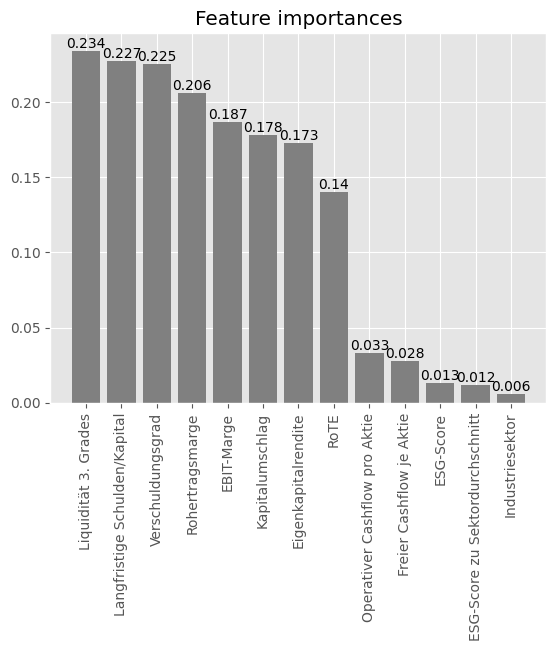

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

class SklearnWrapper:
    def __init__(self, model: nn.Module, device: str):
        self.model = model
        self.device = device

    def fit(self, X: np.ndarray, y: np.ndarray):
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = torch.tensor(X, dtype=torch.float).to(device)
        self.model.eval()
        with torch.no_grad():
            output = self.model(X)
        return np.argmax(output.cpu().numpy(), axis=1)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.predict(X)
        return (y_pred == y).mean()

def measure_importance(model: nn.Module, X_test: torch.Tensor, y_test: torch.Tensor) -> np.ndarray:
    model_sklearn = SklearnWrapper(model, device)
    X_test_np = X_test.cpu().numpy()
    y_test_np = np.argmax(y_test.cpu().numpy(), axis=1)
    r = permutation_importance(model_sklearn, X_test_np, y_test_np, n_repeats=30)
    return r

r = measure_importance(model.to(device), X_test.cpu(), y_test.cpu())

importances = r.importances_mean
std = r.importances_std
indices = np.argsort(importances)[::-1]

importances = np.round(importances, decimals=3)

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="grey", align="center")
plt.xticks(range(X_test.shape[1]), feature_names, rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
ax = plt.subplot()
plt.bar_label(ax.containers[0])
plt.show()


# Lift and gains analysis on class level

C:\Users\leand\AppData\Local\Temp\ipykernel_11392\1205749110.py:17: RuntimeWarning: divide by zero encountered in divide
  lift = cumulative_gains/baseline


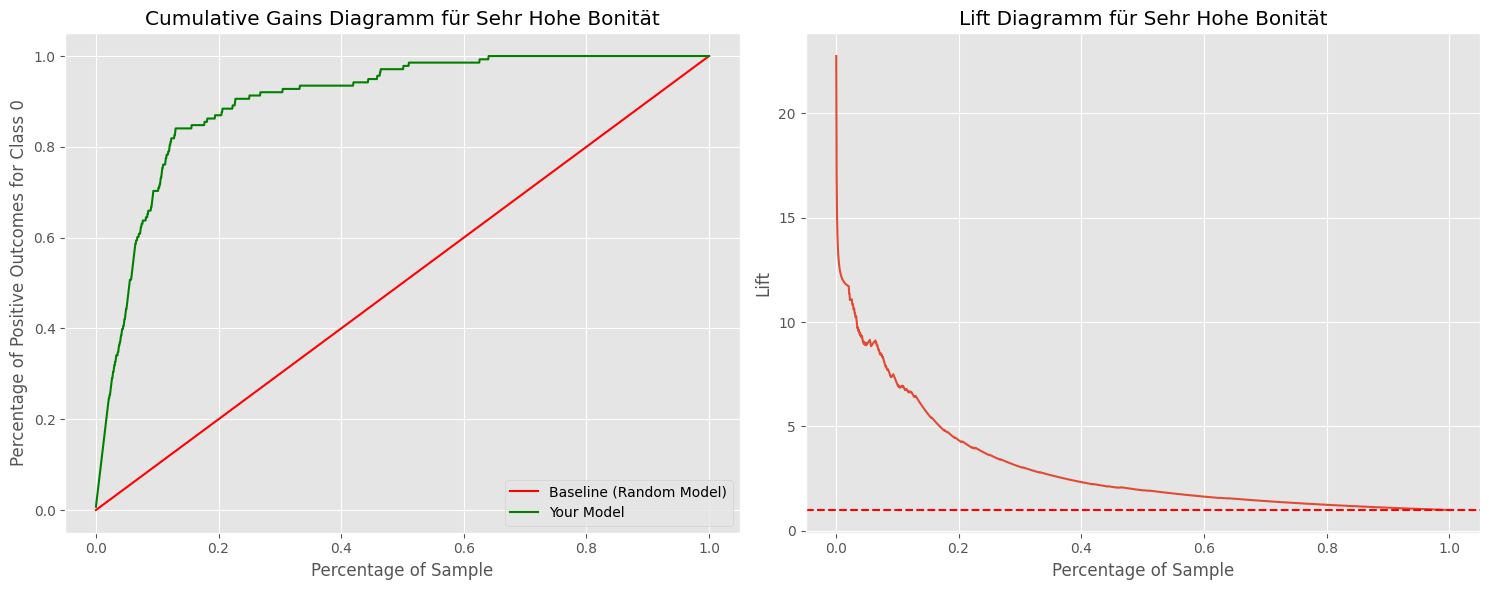

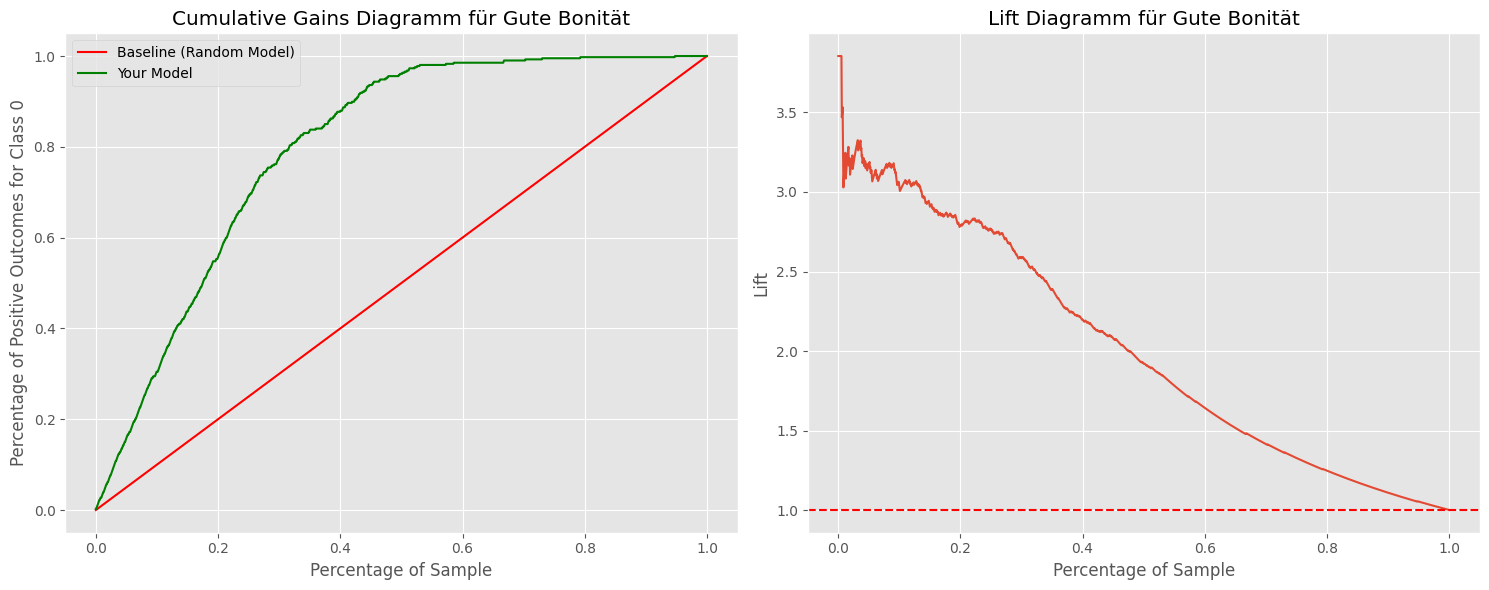

C:\Users\leand\AppData\Local\Temp\ipykernel_11392\1205749110.py:17: RuntimeWarning: invalid value encountered in divide
  lift = cumulative_gains/baseline


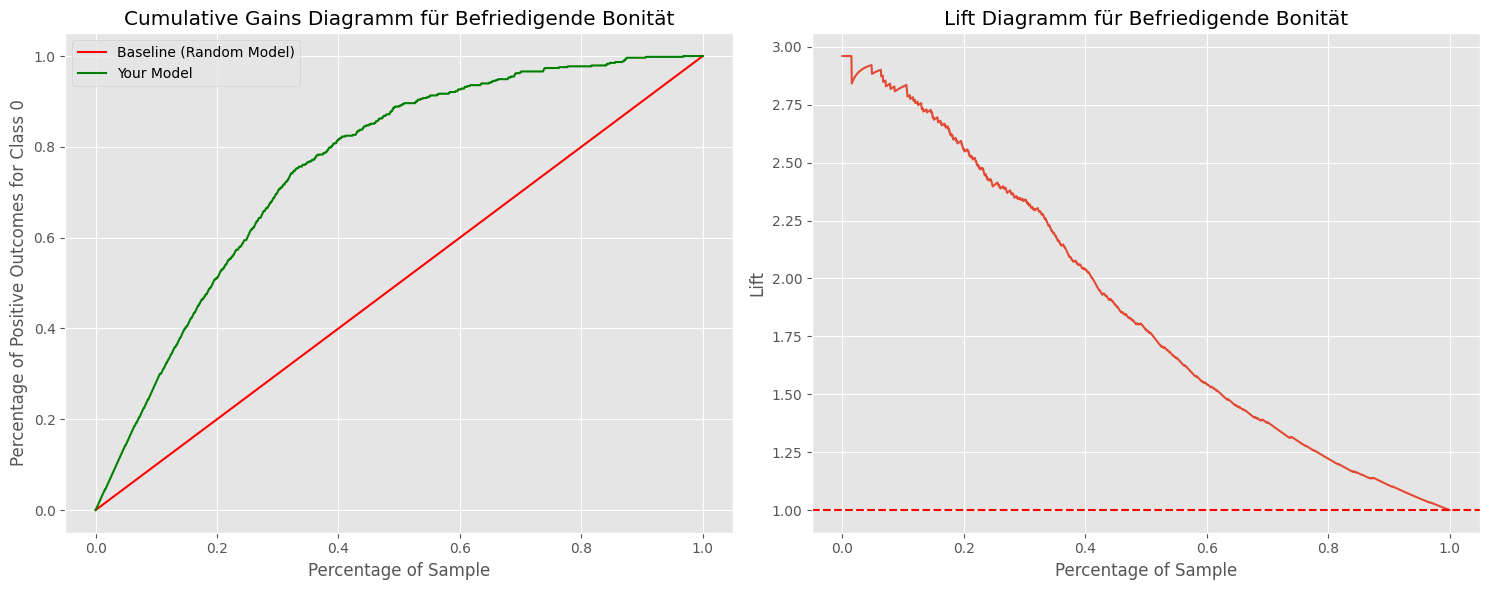

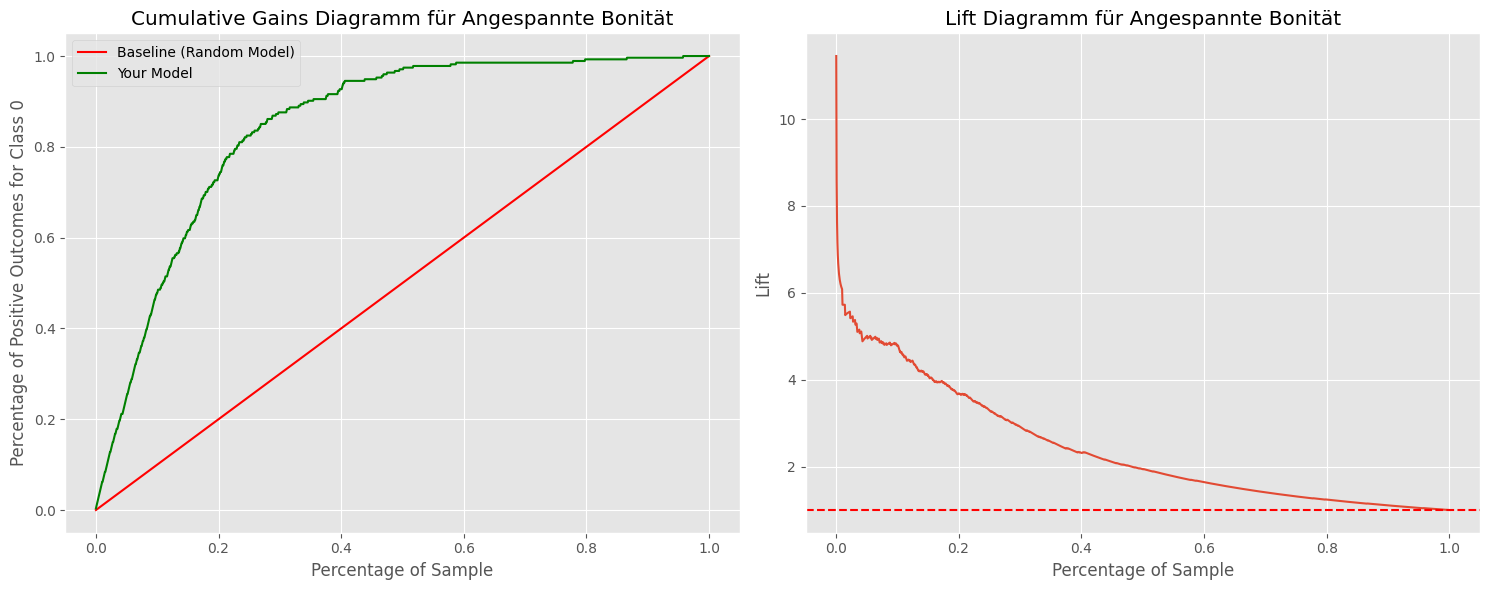

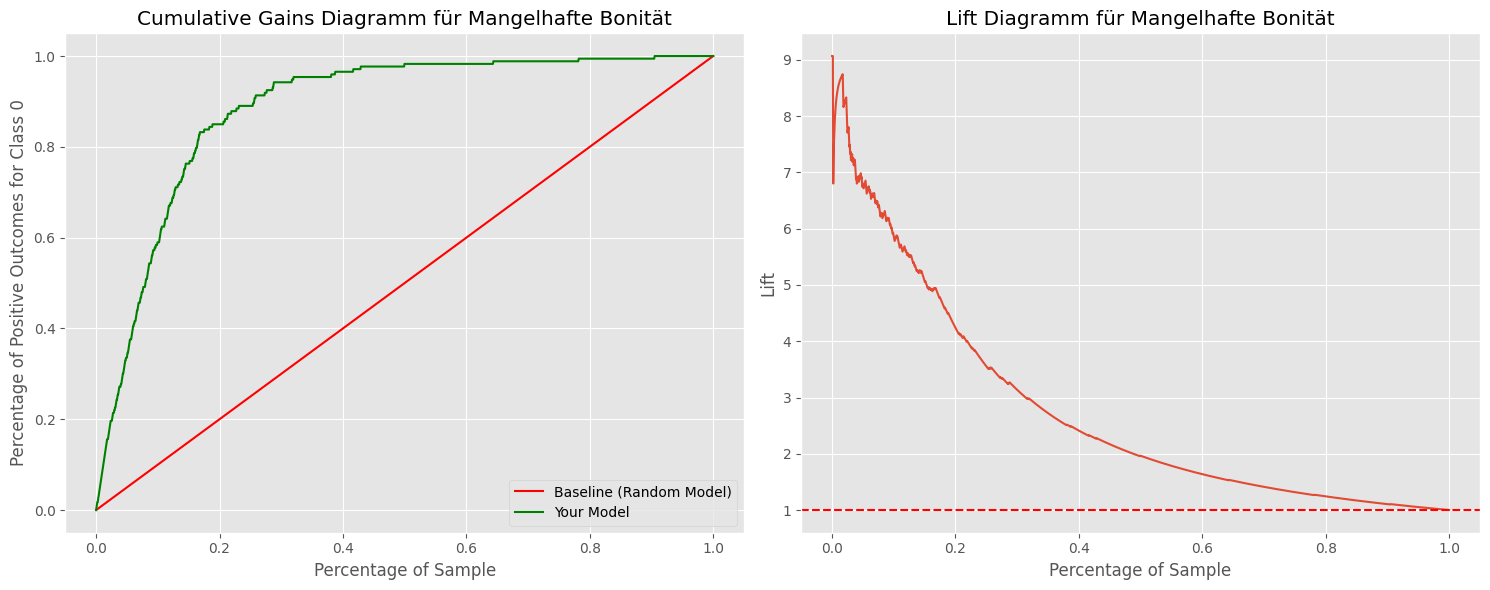

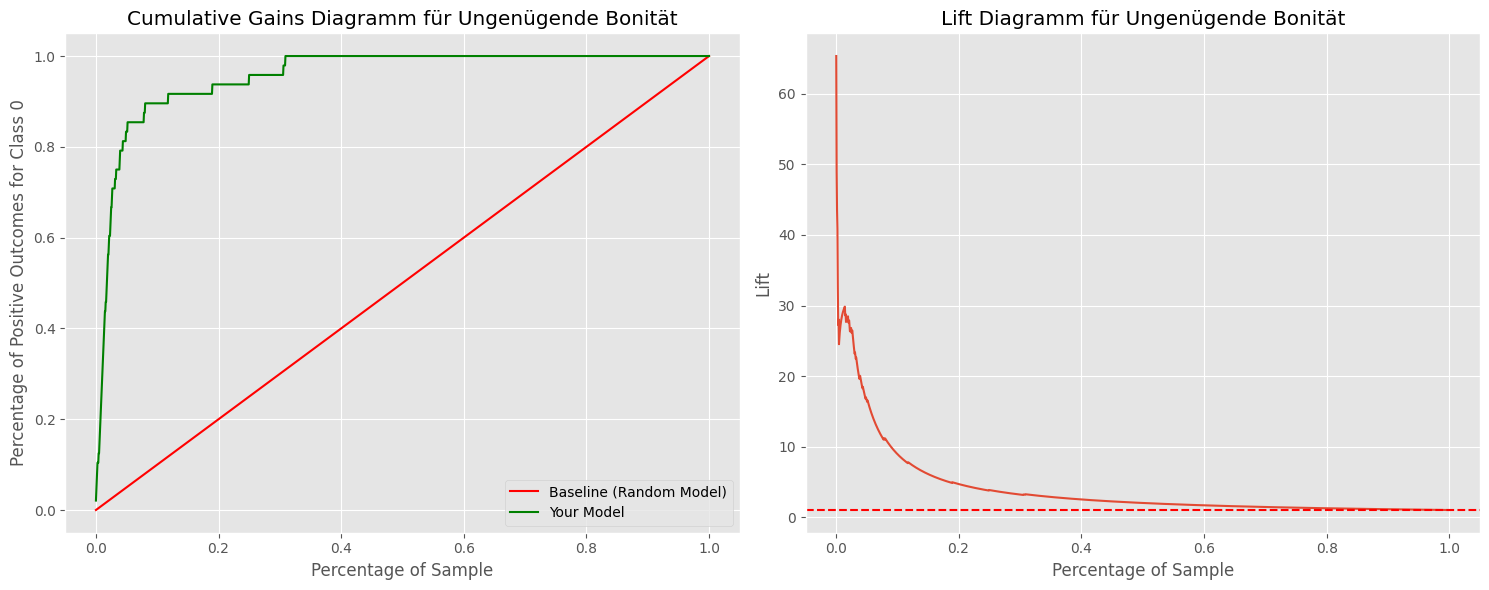

In [11]:

model.eval()

with torch.no_grad():
    y_scores_tensor = model(X_test.to(device))

for i, class_name in enumerate(class_names):

    y_true = y_test.detach().cpu().numpy()[:, i]
    y_scores = y_scores_tensor.detach().cpu().numpy()[:, i]

    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]

    cumulative_gains = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    baseline = np.linspace(0, 1, len(y_true))

    lift = cumulative_gains/baseline

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    ax[0].plot(baseline, baseline, 'r', label="Baseline (Random Model)")
    ax[0].plot(baseline, cumulative_gains, 'g', label="Your Model")
    ax[0].legend()
    ax[0].set_title(f"Cumulative Gains Diagramm für {class_name}")
    ax[0].set_xlabel("Percentage of Sample")
    ax[0].set_ylabel("Percentage of Positive Outcomes for Class 0")

    # Lift Chart
    ax[1].plot(baseline, lift)
    ax[1].axhline(y=1, color='red', linestyle='--')
    ax[1].set_title(f"Lift Diagramm für {class_name}")
    ax[1].set_xlabel("Percentage of Sample")
    ax[1].set_ylabel("Lift")

    plt.tight_layout()
    plt.show()

In [12]:
df_gains = pd.DataFrame({'gains': cumulative_gains, 'lift': lift, 'baseline': baseline})

df_gains.to_csv(os.path.join('torch_eval', 'esg_model', 'gains_esg_class1.csv'))

C:\Users\leand\AppData\Local\Temp\ipykernel_11392\54196330.py:19: RuntimeWarning: divide by zero encountered in divide
  lift = cumulative_gains/baseline
C:\Users\leand\AppData\Local\Temp\ipykernel_11392\54196330.py:19: RuntimeWarning: invalid value encountered in divide
  lift = cumulative_gains/baseline


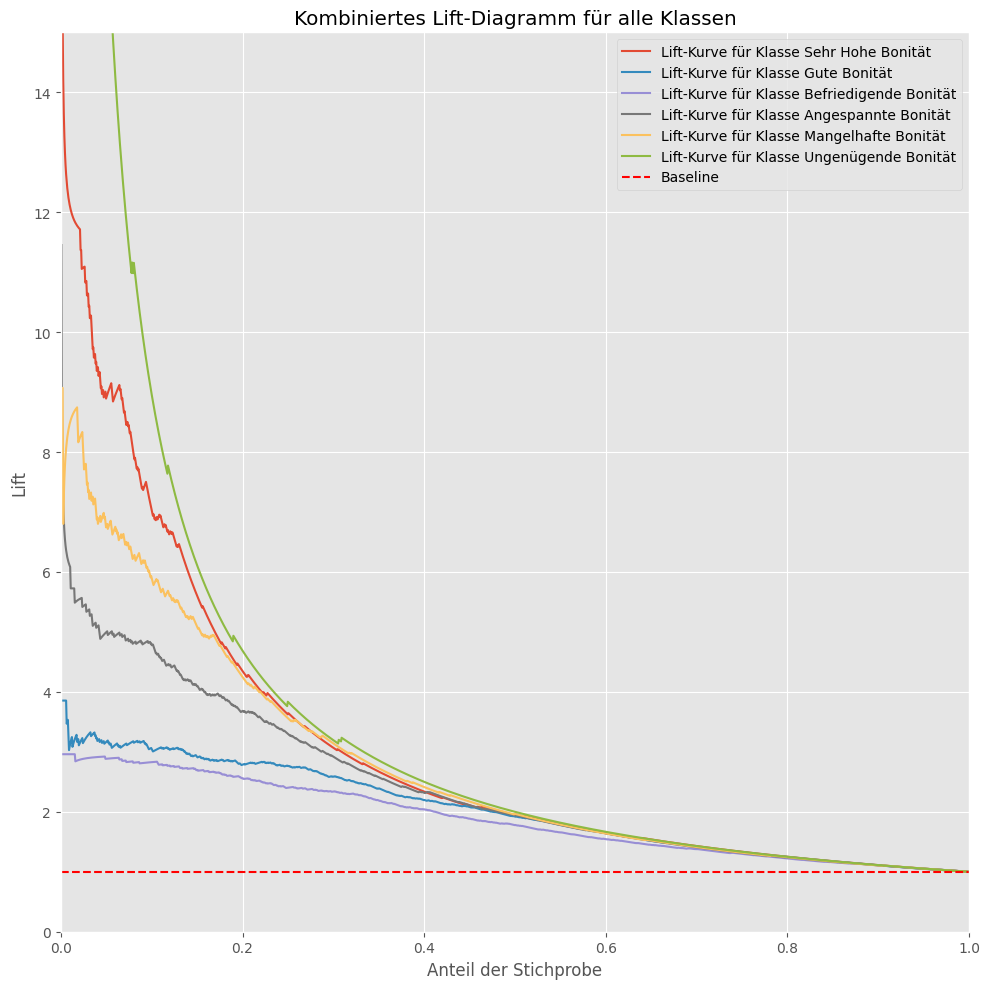

In [13]:
model.eval()

with torch.no_grad():
    y_scores_tensor = model(X_test.to(device))

fig, ax = plt.subplots(figsize=(10, 10))

for i, class_name in enumerate(class_names):

    y_true = y_test.detach().cpu().numpy()[:, i]
    y_scores = y_scores_tensor.detach().cpu().numpy()[:, i]

    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]

    cumulative_gains = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    baseline = np.linspace(0, 1, len(y_true))

    lift = cumulative_gains/baseline

    ax.plot(baseline, lift, label=f"Lift-Kurve für Klasse {class_name}")


ax.axhline(y=1, color='red', linestyle='--', label='Baseline')
ax.set_title(f"Kombiniertes Lift-Diagramm für alle Klassen")
ax.set_xlabel("Anteil der Stichprobe")
ax.set_ylabel("Lift")
plt.ylim(0 ,15)
plt.xlim(0, 1)
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join('torch_eval', 'esg_model', 'lift_diagram_all_classes.png'), dpi=300, bbox_inches='tight')
plt.show()